Date: Nov 20, 2024

# EE5573 Project

*This project aims to explore and build a binary classifier, and filter out the top-10 important influential factors in life-expectancy of patients with breast cancer. Our model includes Random Forest, Gradient Boosted Trees, Logistic Regression and Support Vector Machine.*

## Part 1: Data Processing

*In this part, we will*
* read out the dataset, 
* handle missing data, 
* standardize the dataset,
* split the dataset into training and test set,
* determine the number of pricipal components by PCA,
* perform PCA on the training and test set, and
* determine top-10 important features.

### Part 1.1 - Raw Data

In this version, we remove the sparse columns with more than 95% of 0s or 1s after one-hot encoding. The number of features is reduced to about 570 from 8500.

In [1]:
#########################################################################
# Scaler: Standard scaler
# Features: drop off all >95% 0s and 1s
# Scale all Numerical Columns and one-hot encoding
# Fine tunning is performed on RF.
#########################################################################

import pandas as pd
from sklearn.impute import KNNImputer
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('METABRIC_RNA_Mutation.csv', low_memory=False)

# Drop unwanted columns
columns_to_drop = ['patient_id', 'overall_survival', 'death_from_cancer']
data.drop(columns=columns_to_drop, inplace=True)

# KNN imputation for numeric columns
cols_with_missing = data.columns[data.isnull().any()].tolist()
numeric_columns = [col for col in cols_with_missing if data[col].dtype == 'float64']
imputer = KNNImputer(n_neighbors=5)
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# One-hot encoding for categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
data = pd.get_dummies(data, columns=categorical_columns, prefix=categorical_columns, 
                      dummy_na=False, dtype=int)

# Remove redundant columns (categorical columns with >95% 0s or >95% 1s)
redundant_columns = [
    col for col in data.columns 
    if data[col].nunique() == 2 and (data[col].value_counts(normalize=True).iloc[0] > 0.95)
]
data.drop(columns=redundant_columns, inplace=True)

# Generate the 'survival' column based on 'overall_survival_month'
# Y=-1 stands for less than 10 yrs, Y=1 stands for at least 10 yrs
data = data.copy()
months = [
    (data['overall_survival_months'] < 120),
    (data['overall_survival_months'] >= 120)
]
years = [-1, 1]  
data['survival'] = np.select(months, years, default=np.nan).astype(int) 
data.drop(columns=['overall_survival_months'], inplace=True)

# Split into input training and test set with a ratio of 0.2
X = data.drop(columns=['survival'])
Y = data['survival']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Scale the numeric columns in training and test datasets respectively.
# Scaling is not necessary for all tree-based algorithms.  
binary_columns = [col for col in X_train.columns if set(X_train[col].unique()) <= {0, 1}]
columns_to_scale = [col for col in data.columns if col not in binary_columns and col != 'survival']

# Initiate a substance to scale all features into N(0,1)
scaler=StandardScaler()

# Hard copy dataset
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print out the number of features after preprocessing
print("# of features: ", X_train.shape[1])

# Define feature names in order.
feature_names = X.columns

# Write datasets into files for checking
np.savetxt("X_train_scaled.csv", X_train_scaled, delimiter=",")
np.savetxt("X_test_scaled.csv", X_test_scaled, delimiter=",")
np.savetxt("Y_train.csv", Y_train, delimiter=",")
np.savetxt("Y_test.csv", Y_test, delimiter=",")

# of features:  574


### Part 1.2 Self-defined Functions
*Put all self-defined fuctions in this section.*

In [2]:
def printTop10Features(feature_names, feature_importance):
    ##############################################################################
    # Call this function to return the name of features with descending importance
    # Feature_names: we have defined them in Part 1.1
    # Feature_importance: a vector in length of feature_names
    # This function has no return.
    ##############################################################################
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    print("\nTop 10 important features:")
    print(feature_importance_df.head(10))
    

### Part 1.3 PCA

Retain # of Principal Components =  351
Shape of training set after PCA:  (1523, 351)
Shape of test set after PCA:  (381, 351)

Top 10 important features:
                                Feature  Importance
291                               gata3    0.121431
517                  er_status_Positive    0.106684
516                  er_status_Negative    0.106684
153                               chek1    0.104775
290                                cbfb    0.104041
255                                rheb    0.101682
313                                mapt    0.101662
81                                 dtx3    0.101168
445                                  ar    0.100415
514  er_status_measured_by_ihc_Negative    0.098399


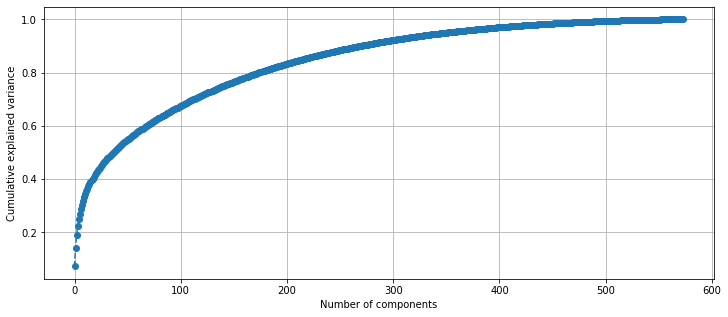

In [3]:
# Import PCA model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA to data
pca = PCA()
pca.fit(X_train_scaled)
evr = pca.explained_variance_ratio_
 
# Visualize the variance explained by each principal components
# Generate a plot
#   X-axis for 'number of principal components', y-axis for "Cumulative explained variance".
#   This plot shows how many principal components should be adopted to satisfactorily represent
#   the original raw data. Set the threshold to 0.8 or 0.95 (by experiment, 0.8 is more 
#   preferrable). We can then determine the reduced dimensionality (around 1000 or 1500).
plt.figure(figsize=(12, 5))
plt.plot(range(0, len(evr)), evr.cumsum(), marker="o", linestyle="--")
plt.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.savefig('fig_1.png', dpi=300)

# Cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to retain
num_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print("Retain # of Principal Components = ",num_components)

# Transform both train and test dataset into lower dimentionality
clf = PCA(n_components = num_components) 
clf.fit(X_train_scaled)
X_train_r = clf.transform(X_train_scaled)
X_test_r = clf.transform(X_test_scaled)
print("Shape of training set after PCA: ", X_train_r.shape)
print("Shape of test set after PCA: ", X_test_r.shape)

# Analyze the composition of pricipal components 
# to determine the top-10 features in the original dataset

# Get the loadings
loadings = pca.components_
coefficients = np.abs(loadings)
feature_importance = coefficients[0,:]

# Print out a list of top-10 important features
printTop10Features(feature_names, feature_importance)


##### Part 2: Models

*In this part, we will try 4 models with datasets.*
* Part 2.1 Random Forest.
* Part 2.2 Gradient Boosted Trees.
* Part 2.3 Logistic Regreesion with L1 Regularization.
* Part 2.4 Support Vector Machine with L1 Regularization.

*By far, we have 3 forms of training and test sets. In summary,*
* Each training set has 1523 samples (as rows), and test set has 381 samples,
* X_train, X_test : 
             raw (neither scaling nor dimension reduction), 574 features (as columns),
* X_train_scaled, X_test_scaled: 
             scaled (with scaling but without dimension reduction), 574 features,
* X_train_r, X_test_r :
             reduced by PCA (with both scaling and dimension reduction), 266 features only.

### Part 2.1 Random Forest (RF)

In [24]:
# Generate 3 containers to store the results for our models.
model_name = []
acc_train = []
acc_test = []

# Import random forest model
from sklearn.ensemble import RandomForestClassifier

# Experiment 2.1.1
# Feed with raw data (X_train and X_test)
clf = RandomForestClassifier(n_estimators=100, max_depth=5, min_samples_split=2, 
                       min_samples_leaf=1, max_features='sqrt', random_state=42).fit(X_train, Y_train)

# Evaluate model
model_name.append('RF')
acc_train.append(clf.score(X_train, Y_train))
acc_test.append(clf.score(X_test, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))

# Feature importance
feature_importance = clf.feature_importances_

# Print out a list of top-10 important features
printTop10Features(feature_names, feature_importance)

Training accuracy: 0.8818
Testing  accuracy: 0.6220

Top 10 important features:
                           Feature  Importance
7      nottingham_prognostic_index    0.023802
5    lymph_nodes_examined_positive    0.022216
0                 age_at_diagnosis    0.018968
131                          aurka    0.015346
9                       tumor_size    0.015208
2                           cohort    0.009813
10                     tumor_stage    0.008655
64                          stat5b    0.007707
160                         diras3    0.007637
349                          dnah2    0.007161


In [26]:
###########################################################################
# Grid Search for RF:
#    Adjust the hyperparmeters. Always set random_state=42.
# Our Goals:
#     - higher testing accuracy
#     - smaller gap between training and testing accuracy
#     - more top-10 features found in {0,2,5,7,9}
###########################################################################


from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(max_features='sqrt', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, Y_train)


# Best hyperparameters and model
print('Best Parameters:\n', grid_search.best_params_) 
clf = grid_search.best_estimator_  # best model

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))

# Feature importance
feature_importance = clf.feature_importances_

# Print out a list of top-10 important features
printTop10Features(feature_names, feature_importance)

Best Parameters:
 {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training accuracy: 0.8818
Testing  accuracy: 0.6220

Top 10 important features:
                           Feature  Importance
7      nottingham_prognostic_index    0.014487
0                 age_at_diagnosis    0.012266
5    lymph_nodes_examined_positive    0.011423
9                       tumor_size    0.006477
64                          stat5b    0.006346
131                          aurka    0.005563
2                           cohort    0.005460
349                          dnah2    0.005363
10                     tumor_stage    0.005146
299                          runx1    0.004692


In [5]:
# Experiment 2.1.2
# Feed with feature-reduced data (X_train_r and X_test_r)
clf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=2, 
                       min_samples_leaf=1, max_features='sqrt', random_state=42).fit(X_train_r, Y_train)

# Evaluate model
model_name.append('RF')
acc_train.append(clf.score(X_train_r, Y_train))
acc_test.append(clf.score(X_test_r, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))


Training accuracy: 0.8976
Testing  accuracy: 0.5958


### Part 2.2 Gradient Boosted Trees (GBT)

In [6]:
# Import selected model
from sklearn.ensemble import GradientBoostingClassifier

# Experiment 2.2.1
# Feed with raw data (X_train and X_test)
clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.01, random_state=42
    ).fit(X_train, Y_train)

# Evaluate model
model_name.append('GBT')
acc_train.append(clf.score(X_train, Y_train))
acc_test.append(clf.score(X_test, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))

# Feature importance
feature_importance = clf.feature_importances_

# Print out a list of top-10 important features
printTop10Features(feature_names, feature_importance)

Training accuracy: 0.7196
Testing  accuracy: 0.6063

Top 10 important features:
                           Feature  Importance
7      nottingham_prognostic_index    0.174718
0                 age_at_diagnosis    0.153824
2                           cohort    0.102761
5    lymph_nodes_examined_positive    0.097151
131                          aurka    0.071722
349                          dnah2    0.044351
64                          stat5b    0.029583
276                          tgfb2    0.017126
106                          psen1    0.015647
454                        cyp21a2    0.015285


In [7]:
# Experiment 2.2.2
# Feed with feature-reduced data (X_train_r and X_test_r)
clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.01, random_state=42
    ).fit(X_train_r, Y_train)

# Evaluate model
model_name.append('GBT')
acc_train.append(clf.score(X_train_r, Y_train))
acc_test.append(clf.score(X_test_r, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))


Training accuracy: 0.7505
Testing  accuracy: 0.5906


### Part 2.3 Logistic Regression (LR)

In [8]:
# Import LR model
from sklearn.linear_model import LogisticRegression

# Experiment 2.3.1
# Feed with scaled data (X_train_scaled and X_test_scaled)
clf = LogisticRegression(
    C=0.1, penalty="l1", tol=1e-4, max_iter=2000, solver="saga"
    ).fit(X_train_scaled, Y_train)

# Evaluate model
model_name.append('LR')
acc_train.append(clf.score(X_train_scaled, Y_train))
acc_test.append(clf.score(X_test_scaled, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))

# Feature importance
feature_importance = np.abs(clf.coef_).reshape(-1,)

# Print out a list of top-10 important features
printTop10Features(feature_names, feature_importance)

Training accuracy: 0.7768
Testing  accuracy: 0.6430

Top 10 important features:
                           Feature  Importance
0                 age_at_diagnosis    0.437897
5    lymph_nodes_examined_positive    0.352527
26                            pms2    0.283335
389                           nras    0.174198
349                          dnah2    0.163974
43                           ccnd2    0.147768
210                          mapk7    0.144232
31                             rb1    0.141463
64                          stat5b    0.137726
462                       hsd17b11    0.135437


In [9]:
# Experiment 2.3.2
# Feed with feature-reduced data (X_train_r and X_test_r)
clf = LogisticRegression(
    C=0.025, penalty="l1", tol=1e-4, max_iter=2000, solver="saga"
    ).fit(X_train_r, Y_train)

# Evaluate model
model_name.append('LR')
acc_train.append(clf.score(X_train_r, Y_train))
acc_test.append(clf.score(X_test_r, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))


Training accuracy: 0.6612
Testing  accuracy: 0.6273


### Part 2.4 Support Vector Machine (SVM)

In [10]:
# Import SVM model
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Experiment 2.4.1
# Feed with scaled data (X_train_scaled and X_test_scaled)
clf = LinearSVC(
    C=0.025, penalty="l1", tol=1e-5, max_iter=2000, dual=False, random_state=42
    ).fit(X_train_scaled, Y_train)

# Evaluate model
model_name.append('SVM')
acc_train.append(clf.score(X_train_scaled, Y_train))
acc_test.append(clf.score(X_test_scaled, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))

# Feature importance
feature_importance = np.abs(clf.coef_).reshape(-1,)

# Print out a list of top-10 important features
printTop10Features(feature_names, feature_importance)

Training accuracy: 0.7682
Testing  accuracy: 0.6404

Top 10 important features:
                           Feature  Importance
0                 age_at_diagnosis    0.183367
5    lymph_nodes_examined_positive    0.127042
26                            pms2    0.115648
389                           nras    0.073617
349                          dnah2    0.067434
43                           ccnd2    0.060861
210                          mapk7    0.059240
64                          stat5b    0.059010
31                             rb1    0.057590
462                       hsd17b11    0.056089


In [11]:
# Experiment 2.4.2
# Feed with feature-reduced data (X_train_r and X_test_r)
clf = LinearSVC(
    C=0.01, penalty="l1", tol=1e-4, max_iter=2000, dual=False, random_state=42
    ).fit(X_train_r, Y_train)

# Evaluate model
model_name.append('SVM')
acc_train.append(clf.score(X_train_r, Y_train))
acc_test.append(clf.score(X_test_r, Y_test))

# Print out the accuracy for training and test sets
print("Training accuracy: {:.4f}".format(acc_train[-1]))
print("Testing  accuracy: {:.4f}".format(acc_test[-1]))


Training accuracy: 0.6888
Testing  accuracy: 0.6247


## Part 3: Discussions

*In this part, we will compare and discuss the differeces between outputs from the raw and feature-reduced data of the 4 models in terms of*
* Part 3.1 Accuracy
* Part 3.2 Top-10 selected fetures

### Part 3.1 Model Accuracy

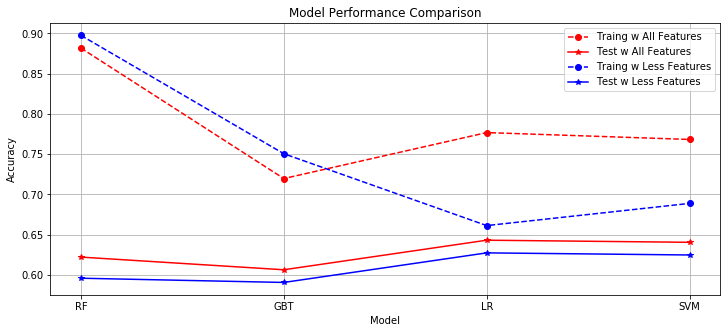

In [12]:
# Plot 4 curves 
#   Color in red for raw data, blue for feature-reduced data.
#   Solid line for training accuracy, dash line for test accuracy.
#   X-axis for name of the 4 models, y-axis for model accuracy.


# Model names and their corresponding training accuracies
models = model_name[::2]
acc_train_1 = acc_train[::2]
acc_test_1 = acc_test[::2]
acc_train_2 = acc_train[1::2]
acc_test_2 = acc_test[1::2]

# Create a line plot
plt.figure(figsize=(12, 5))
plt.plot(models, acc_train_1, marker='o', color='red', linestyle='--', label='Traing w All Features')
plt.plot(models, acc_test_1, marker='*', color='red', linestyle='-', label='Test w All Features')
plt.plot(models, acc_train_2, marker='o', color='blue', linestyle='--', label='Traing w Less Features')
plt.plot(models, acc_test_2, marker='*', color='blue', linestyle='-', label='Test w Less Features')

# Customize the plot
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [14]:
print(model_name,acc_train,acc_test)

['RF', 'RF', 'GBT', 'GBT', 'LR', 'LR', 'SVM', 'SVM'] [0.881812212738017, 0.8975705843729481, 0.7196323046618516, 0.7504924491135916, 0.7767564018384767, 0.6611950098489823, 0.768220617202889, 0.6887721602101117] [0.6220472440944882, 0.5958005249343832, 0.6062992125984252, 0.5905511811023622, 0.6430446194225722, 0.6272965879265092, 0.6404199475065617, 0.6246719160104987]
